<a href="https://colab.research.google.com/github/udfds/DataLab/blob/master/exercises/365datascience/time_series_analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:
https://365datascience.teachable.com/courses/enrolled/666338

## Install libs

In [0]:
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install arch

     |████████████████████████████████| 727kB 2.8MB/s 


## Import libs

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pylab

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats.distributions import chi2
from google.colab import files
from google.colab import drive

sns.set()

## Load datataframe

In [0]:
df_draft = pd.read_csv('Index2018.csv')

df_timeseries = df_draft.copy()

df_timeseries.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


## Exploring the Data

In [0]:
# Aboute the data frame
# spx    = S&P 500  (USA)
# dax    = DAX 30  (German)
# ftse   = FTSE 100  (UK)
# nikkei = NIKKEI 225  (Japan)

In [0]:
df_timeseries.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


In [0]:
df_timeseries.isna().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

## Plotting the Data

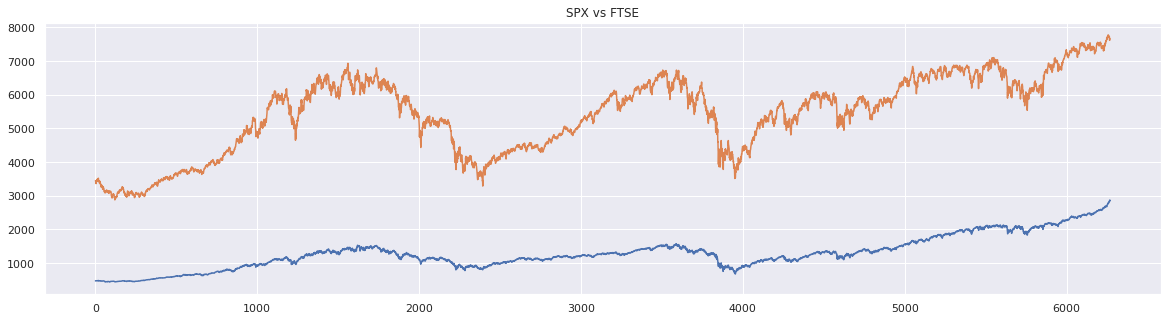

In [0]:
df_timeseries.spx.plot(figsize=(20, 5))
df_timeseries.ftse.plot(figsize=(20, 5))

plt.title('SPX vs FTSE');

## The QQ Plot

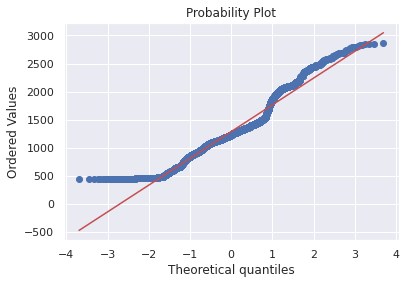

In [0]:
scipy.stats.probplot(df_timeseries.spx, plot = pylab)
pylab.show()

## Convert Text in Date and setting the Index

In [0]:
df_timeseries.date = pd.to_datetime(df_timeseries.date, dayfirst=True)

df_timeseries.set_index('date', inplace=True)

df_timeseries.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


## Setting the frequency

In [0]:
# Business days = 'b'
df_timeseries = df_timeseries.asfreq('b')
df_timeseries.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


## Handling Missing values (after use frequency)

In [0]:
df_timeseries.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [0]:
df_timeseries.spx = df_timeseries.spx.fillna(method='ffill')
df_timeseries.ftse = df_timeseries.ftse.fillna(method='bfill')
df_timeseries.dax = df_timeseries.dax.fillna(value=df_timeseries.dax.mean())
df_timeseries.nikkei = df_timeseries.nikkei.fillna(method='ffill')

df_timeseries.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

## Simplifying the Dataset

In [0]:
df_timeseries['market_value'] = df_timeseries.spx
del  df_timeseries['spx'], df_timeseries['dax'], df_timeseries['ftse'], df_timeseries['nikkei']

df_timeseries.describe()

,market_value
count,6277.000000
mean,1288.642547
std,487.868210
min,438.920000
25%,992.715221
50%,1233.761241
75%,1460.250000
max,2872.867839


## Splitting up the Data

In [0]:
size = int(len(df_timeseries)*0.8)

df_training = df_timeseries.iloc[:size]
df_test = df_timeseries.iloc[size:]

## White Noise

In [0]:
white_noise = np.random.normal(loc=df_training.market_value.mean(), scale=df_training.market_value.std(), size=len(df_training))
df_training['white_noise'] = white_noise

df_training.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,market_value,white_noise
count,5021.000000,5021.000000
mean,1091.651926,1090.792254
std,292.559287,294.146187
min,438.920000,-145.042441
25%,914.620000,891.589627
50%,1144.650000,1093.276536
75%,1316.280729,1290.425323
max,1570.252238,2169.832765


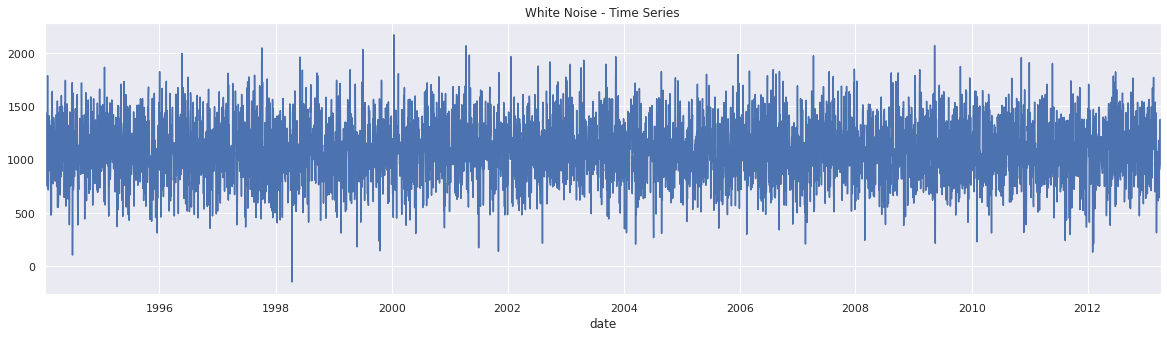

In [0]:
df_training.white_noise.plot(title='White Noise - Time Series', figsize=(20, 5));

(0.0, 2300.0)

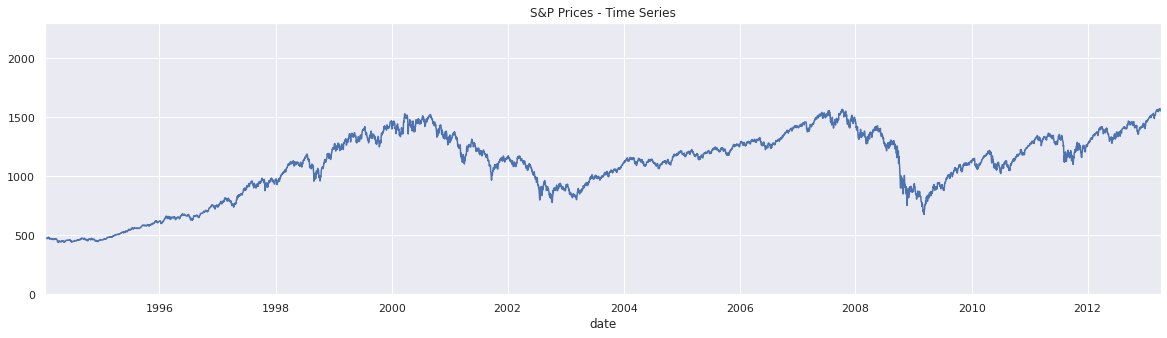

In [0]:
df_training.market_value.plot(title='S&P Prices - Time Series', figsize=(20, 5));
plt.ylim(0, 2300)

## Random Walks

In [0]:
df_random_walks = pd.read_csv('RandWalk.csv')
df_random_walks.date = pd.to_datetime(df_random_walks.date, dayfirst=True)

df_random_walks.set_index('date', inplace=True)
df_random_walks = df_random_walks.asfreq('b')

df_random_walks.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [0]:
df_training['random_walk'] = df_random_walks.price

df_training.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,market_value,white_noise,random_walk
date,,,
1994-01-07,469.90,727.273641,1122.139662
1994-01-10,475.27,893.235564,1080.347860
1994-01-11,474.13,1428.059814,1082.095245
1994-01-12,474.17,1178.538734,1083.639265
1994-01-13,472.47,847.892176,1067.146255


Text(0.5, 1.0, 'Random Walk vs S&P')

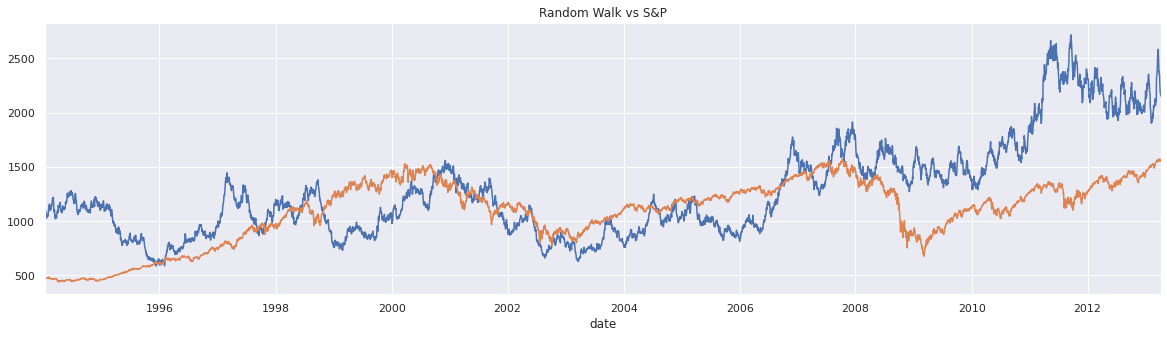

In [0]:
df_training.random_walk.plot(figsize=(20,5));
df_training.market_value.plot(figsize=(20,5));

plt.title('Random Walk vs S&P')

## Stattionaryity

In [0]:
sts.adfuller(df_training.market_value)

(-1.736984745235244,
 0.41216456967706194,
 18,
 5002,
 {'1%': -3.431658008603046,
  '10%': -2.567077669247375,
  '5%': -2.862117998412982},
 39904.880607487445)

In [0]:
sts.adfuller(df_training.white_noise)

(-71.01685661311866,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '10%': -2.5670765656497516,
  '5%': -2.8621159253018247},
 70862.01417841604)

In [0]:
sts.adfuller(df_training.random_walk)

(-1.3286073927689708,
 0.6159849181617388,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '10%': -2.567078038881065,
  '5%': -2.8621186927706463},
 46299.333497595144)

## Seasonality

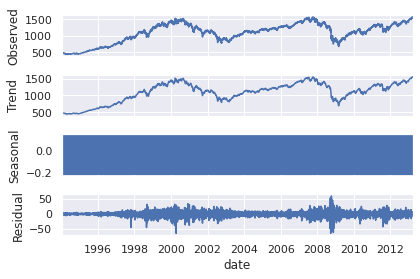

In [0]:
decompose_additive = seasonal_decompose(df_training.market_value, model='additive')
decompose_additive.plot();

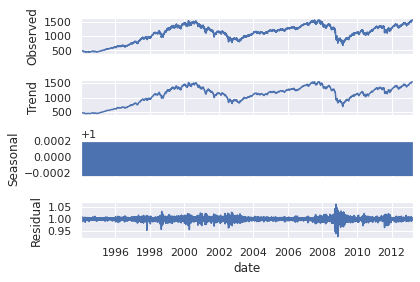

In [0]:
decompose_multiplicative = seasonal_decompose(df_training.market_value, model='multiplicative')
decompose_multiplicative.plot();

## Correlation - ACF (Autocorrelation Function)

- Also Serial correlation, is the correlation of a signal with a delayed copy of itself as a function of delay

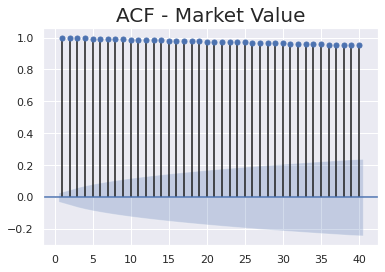

In [0]:
sgt.plot_acf(df_training.market_value, unbiased=True, zero=False, lags=40)
plt.title('ACF - Market Value', size=20);

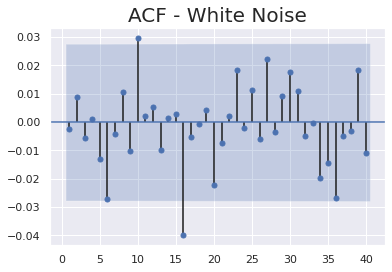

In [0]:
sgt.plot_acf(df_training.white_noise, unbiased=True, zero=False, lags=40)
plt.title('ACF - White Noise', size=20);

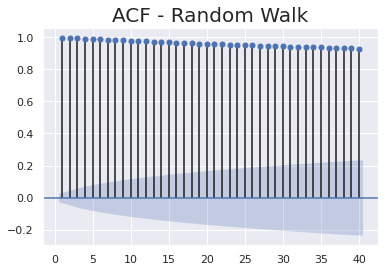

In [0]:
sgt.plot_acf(df_training.random_walk, unbiased=True, zero=False, lags=40)
plt.title('ACF - Random Walk', size=20);

## Correlation - PACF (Parcial Autocorrelation Function)

- Partial correlation of s stationary time series with its own lagged values, regressed the values of the time series at all shorter lags.

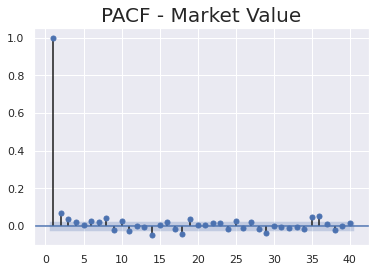

In [0]:
sgt.plot_pacf(df_training.market_value, lags=40, alpha=0.05, zero=False, method=('ols'))
plt.title('PACF - Market Value', size=20);

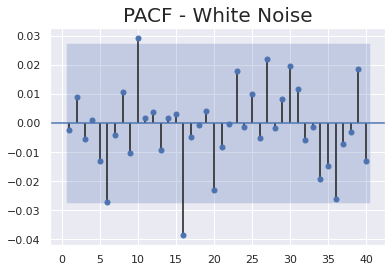

In [0]:
sgt.plot_pacf(df_training.white_noise, lags=40, alpha=0.05, zero=False, method=('ols'))
plt.title('PACF - White Noise', size=20);

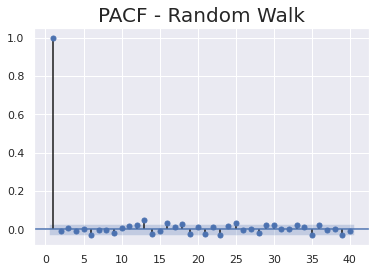

In [0]:
sgt.plot_pacf(df_training.random_walk, lags=40, alpha=0.05, zero=False, method=('ols'))
plt.title('PACF - Random Walk', size=20);

## Autoregressive Model (AR)

- Models uses values of the same variable (auto) to estimate the current one (regression).
- Values from consecutive periods are related.

In [0]:
# Order, argument 1: Number of passed values wish to incorporate into the model
# Order, argument 2: Number of the residual values into consideration
model_ARMA_1 = ARMA(df_training.market_value, order=(1,0))

model_ARMA_1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 0)   Log Likelihood              -20097.388
Method:                       css-mle   S.D. of innovations             13.238
Date:                Fri, 03 Apr 2020   AIC                          40200.776
Time:                        13:41:27   BIC                          40220.340
Sample:                    01-07-1994   HQIC                         40207.631
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1058.2701    228.415      4.633      0.000     610.584    1505.956
ar.L1.market_value     0.9994      0.001   1910.488      0.000       0.998       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0006           +0.0000j            1.0006            0.0000
-----------------------------------------------------------------------------
"""

In [0]:
model_ARMA_2 = ARMA(df_training.market_value, order=(2,0))

#model_ARMA_2.fit().summary()

In [0]:
model_ARMA_3 = ARMA(df_training.market_value, order=(3,0))

#model_ARMA_3.fit().summary()

In [0]:
model_ARMA_4 = ARMA(df_training.market_value, order=(4,0))

#model_ARMA_4.fit().summary()

## LLR Test function

In [0]:
def LLR_test(model_1, model_2, diff=1):
  l1 = model_1.fit().llf
  l2 = model_2.fit().llf
  lr = (2*(l2-l1))
  p = chi2.sf(lr, diff).round(3)
  return p

## Comparing AR Models

In [0]:
model_ARMA_1 = ARMA(df_training.market_value, order=(1,0))
model_ARMA_2 = ARMA(df_training.market_value, order=(2,0))

LLR_test(model_ARMA_1, model_ARMA_2)

0.0

In [0]:
model_ARMA_2 = ARMA(df_training.market_value, order=(2,0))
model_ARMA_3 = ARMA(df_training.market_value, order=(3,0))

LLR_test(model_ARMA_2, model_ARMA_3)

0.015

In [0]:
model_ARMA_3 = ARMA(df_training.market_value, order=(3,0))
model_ARMA_4 = ARMA(df_training.market_value, order=(4,0))

LLR_test(model_ARMA_3, model_ARMA_4)

0.139

In [0]:
model_ARMA_4 = ARMA(df_training.market_value, order=(4,0))
model_ARMA_5 = ARMA(df_training.market_value, order=(5,0))

LLR_test(model_ARMA_4, model_ARMA_5)

0.0

In [0]:
model_ARMA_5 = ARMA(df_training.market_value, order=(5,0))
model_ARMA_6 = ARMA(df_training.market_value, order=(6,0))

LLR_test(model_ARMA_5, model_ARMA_6)

0.055

In [0]:
model_ARMA_6 = ARMA(df_training.market_value, order=(6,0))
model_ARMA_7 = ARMA(df_training.market_value, order=(7,0))

LLR_test(model_ARMA_6, model_ARMA_7)

0.112

In [0]:
model_ARMA_7 = ARMA(df_training.market_value, order=(7,0))
model_ARMA_8 = ARMA(df_training.market_value, order=(8,0))

LLR_test(model_ARMA_7, model_ARMA_8)

0.004

## Using 'returns'

In [0]:
df_training['returns'] = df_training.market_value.pct_change(1).mul(100)
df_training = df_training.iloc[1:]

sts.adfuller(df_training.returns)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(-17.034457190981243,
 8.280537020316232e-30,
 17,
 5002,
 {'1%': -3.431658008603046,
  '10%': -2.567077669247375,
  '5%': -2.862117998412982},
 16035.926219345134)

## ACF & PACF - Returns

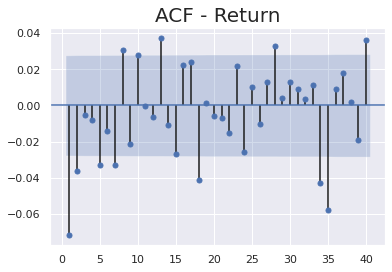

In [0]:
sgt.plot_acf(df_training.returns, unbiased=True, zero=False, lags=40)
plt.title('ACF - Returns', size=20);

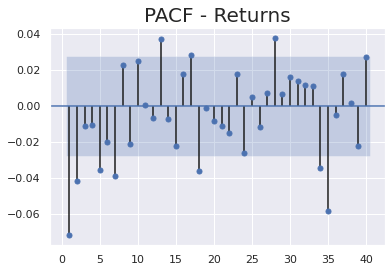

In [0]:
sgt.plot_pacf(df_training.returns, lags=40, alpha=0.05, zero=False, method=('ols'))
plt.title('PACF - Returns', size=20);